In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
from scipy.stats import binned_statistic
import concurrent
import pickle

from scipy.interpolate import splev
from scipy.interpolate.dfitpack import bispeu
from numba import jit

import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)

out_folder = 'results_forward'
# import the parameters
with open('rl_coeff.p', 'rb') as f:
    rl_coeff = pickle.load(f)
# import the hysteresis fits
with open('hysteresis_fits.p', 'rb') as f:
    hyst_fits = pickle.load(f)

In [153]:
from numba import jit

@jit(nopython=True)
def update_hyst_line(L, x):
    # first find out if we went up or down
    if L[-1, 0] < x:
        # we went up, get rid of the history of all elements that have alpha smaller than x
        L[L[:, 0] < x, 0] = x
        # add the newest element
        L = np.vstack((L, np.array([[x, x]])))
        # every other element needs to have a different alpha, otherwise need to get rid of it
        keep = np.zeros(L.shape[0]).astype(np.bool_)
        keep[0] = True
        keep[-1] = True
        for i in range(L.shape[0]-2):
            if L[i, 0] != L[i+1, 0]:
                keep[i] = True
                keep[i+1] = True
        L = L[keep, :]
        return L
    if L[-1, 0] > x:
        # we went up, get rid of the history of all elements that have alpha smaller than x
        L[L[:, 1] > x, 1] = x
        # add the newest element
        L = np.vstack((L, np.array([[x, x]])))
        # every other element needs to have a different alpha, otherwise need to get rid of it
        keep = np.zeros(L.shape[0]).astype(np.bool_)
        keep[0] = True
        keep[-1] = True
        for i in range(L.shape[0]-2):
            if L[i, 1] != L[i+1, 1]:
                keep[i] = True
                keep[i+1] = True
        L = L[keep, :]
        return L
    return L    

# @jit(nopython=False, forceobj=True)
def F_fun(a, b, transition_coeff, main_coeff):
    if a.size == 0:
        return np.array([])
    fa = splev(a, main_coeff)
    tx, ty, c, kx, ky = transition_coeff[:]
    fab = bispeu(tx,ty,c,kx,ky, a, b)[0]
    return ((fa-fab)/2)[0]

# @jit(nopython=False, forceobj=True)
def get_hystline_signal(L,  transition_coeff, main_coeff):
    """Gets the value of the signal having the points of the Prezbiach line and the integral functions"""
    # get alphas and betas
    alpha, beta = L[:, 0], L[:, 1]
    # get all the horisontal lines
    indx_hor = (beta[1:] - beta[:-1]) != 0
#     lenh = np.sum(indx_hor)
#     print(lenh)
    # calcluate the signal
    signal = -F_fun(alpha[0], beta[0], transition_coeff, main_coeff)
    F_kk = F_fun(alpha[:-1][indx_hor], beta[:-1][indx_hor], transition_coeff, main_coeff)
    F_kk1 = F_fun(alpha[1:][indx_hor], beta[1:][indx_hor], transition_coeff, main_coeff)
    signal += 2*np.sum(F_kk - F_kk1)    
    return signal

# @jit(nopython=False, forceobj=True)
def reconstruct_hyst_signal(signal, L_start, transition_coeff, main_coeff):
    # define the starting line
    L = L_start
    signal_out = np.zeros(len(signal))
    for i, x in enumerate(signal):
        L = update_hyst_line(L, x)
        signal_out[i] = get_hystline_signal(L,  transition_coeff, main_coeff)
    return signal_out, L

In [130]:
start_l = hyst_fits['start_l'][0]

In [134]:
splev(1, main_coeff)

array(2.22222033)

In [132]:
main_coeff

(array([-1.83191151, -1.83191151, -1.83191151, -1.83191151, -1.75013625,
        -1.55658608, -0.92511017,  0.74521151,  1.31441726,  1.52154396,
         1.71850304,  1.82372269,  1.82372269,  1.82372269,  1.82372269]),
 array([-8.97987132, -8.22894316, -6.15894042, -2.58505552, -0.55807512,
         0.94982595,  2.55514348,  4.36929163,  6.27038438,  8.18131403,
         9.03270873,  0.        ,  0.        ,  0.        ,  0.        ]),
 3)

In [156]:
import time
signal = hp_signal[:, 1]
signal_short = signal[::10]
t0 = time.time()
reconstruct_hyst_signal(signal_short, start_l, transition_coeff, main_coeff)
print(time.time() - t0)

0.10374021530151367


In [113]:
F_fun(-1, 1, transition_coeff, main_coeff)

-136.86927540623222

In [104]:
F_functions[0](-1, 1)

-136.86927540623222

In [100]:

tx,ty,c = transition_fits[0].tck[:3]
kx,ky = transition_fits[0].degrees
transition_coeff = [tx, ty, c, kx, ky]
main_coeff =  main_branch_fits[0]._eval_args
# bispeu(tx,ty,c,kx,ky,-1, 1)[0]

In [95]:
transition_fits[0](-1, 1)

array([[272.11753959]])

In [91]:
args = main_branch_fits[0]._eval_args


splev(1, args)


array(2.22222033)

In [73]:
def filter_signal(t, signal, bin_step=100):
    # to speed up, filter the high frequency stuff
    signal_bin = binned_statistic(t, [t, signal], bins=int(len(t)/bin_step), statistic='mean').statistic
    return signal_bin[0, :], signal_bin[1, :]

class SignalReconstructor:
    def __init__(self, rl_coeff, hyst_fits, cutoff_freq=100):
        self.main_branch_fits = hyst_fits['main_branch']
        self.transition_fits = hyst_fits['transition_branches']
        # create F_functions
        self.F_functions = [lambda a, b, f_a=f_a, f_ab=f_ab: (f_a.__call__(a) - f_ab.ev(a, b))/2 
                            for f_a, f_ab in zip(main_branch_fits, transition_fits)]
        
        self.poles = [0, 1, 2]
        self.R = [rl_coeff[pole]['R'] for pole in self.poles]
        self.L = [rl_coeff[pole]['L'] for pole in self.poles]
        self.degauss_l = hyst_fits['degauss_l']
        self.start_l = hyst_fits['start_l']
        self.cutoff_freq = cutoff_freq
        self.fitting_displacements = hyst_fits['fitting_displacements']
        self.pole_mxmn = [self.start_l[pole][0, :] for pole in self.poles]

    def get_required_input_pole(self, pole_signal, pole):
        """Gets the required hex signal given the measured/desired hp signal for a given pole. 
        hp_signal is expected to be nx2 array with first column being time.
        Returns the hx_signal"""
        assert pole_signal.shape[1] == 2
        
        # get the pole parameters
        R = self.R[pole]
        L = self.L[pole]
        F_fun = self.F_functions[pole]
        start_l = self.degauss_l[pole].copy()
        ds = self.fitting_displacements[pole]

        t0 = pole_signal[:, 0] 
        # need to add minus because of how the calibration was done
        signal0 = -pole_signal[:, 1]
        # to speed up, filter the high frequency stuff
        t, signal = filter_signal(t0, signal0)
        timestep = t[1] - t[0]

        # first invert the hysteresis. Do it twice because we are having a repetative signal
        signal_nohyst, hyst_line = reconstruct_hyst_signal(signal, start_l, F_fun)
        signal_nohyst, hyst_line = reconstruct_hyst_signal(signal, hyst_line, F_fun)
        # TODO: need to fix this, but there is a 0.1 offset with respect to the hysteresis. 
        #It probably has to do with the magnet saturation
        signal_nohyst += ds

        ## now adjust for the RL response
        # do fft on the signal and extract the frequencies
        n = signal_nohyst.shape[0]
        fft = np.fft.rfft(signal_nohyst, norm='ortho')
        freq = np.fft.rfftfreq(n, d=timestep)
        # get the impedence
        Z = R + 1j*2*np.pi*freq*L

        # kill all of the ampilitudes of signals higher than 200Hz
        fft[freq>100] = 0
        # get fft of voltage
        fft_v = fft*Z
        # invert fft, need to divide by 2 because when ni is applying 1V, the output is actually 2V
        v_pred = np.fft.irfft(fft_v, n=n, norm='ortho')
        v_pred /= 2

        # interpolate back to the original shape
        v_out = np.interp(t0, t, v_pred)
        return v_out

    def get_required_input(self, fields):
        """Gets the required hex signal given the measured/desired fields signal for a given pole. 
        fields is expected to be nx4 array with first column being time, and the other 3 being
        the desired signal for the given time
        Returns the hx_signal in the same shape."""

        out_signal = fields.copy()
        for pole in self.poles:
            out_signal[:, pole+1] = self.get_required_input_pole(hp_signal[:, [0, pole+1]], pole)
        return out_signal
    
    
    
signal_reconstructor = SignalReconstructor(rl_coeff, hyst_fits)

### Import and plot the test signal

-0.006091915421177933
0.0016998966226488405
-0.0020058028442331076


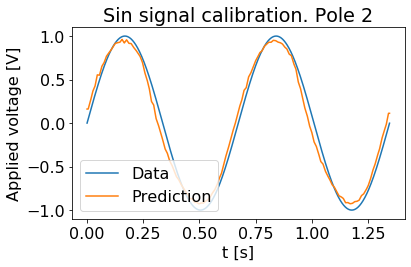

In [72]:
# get the test signal
pole = 2
poles = [0, 1, 2]
poles_dict = {0:'A', 1:'B', 2:'C'}
test_file_path = r"C:\Users\lukas\OneDrive - University of Cambridge\PhD\3DMOKE\Data\MagnetCalibration\magnet_response_complete.h5"
test_num=100
for pole in poles:
    with h5py.File(test_file_path, 'r') as f:
    #     print([f['test_response'].keys()])
        hp_signal = f['frequency_response/pole{}/loops{}/data3/hallprobe/data'.format(pole, test_num)][:]
    #     hp_signal = f['test_response/test{}/hallprobe/data'.format(test_num)][:]
        hp_signal[:, 0] -= hp_signal[0, 0]
        hx_signal = f['frequency_response/pole{}/loops{}/data3/hexapole/data'.format(pole, test_num)][:]
    #     hx_signal = f['test_response/test{}/hexapole/data'.format(test_num)][:]
        hx_signal[:, 0] -= hx_signal[0, 0]

    # fig = plt.figure(figsize=(12, 12))
    # for pl in poles:
    #     plt.subplot(3, 2, 2*pl+1)
    #     plt.plot(hx_signal[:, 0], hx_signal[:, pl+1])
    #     plt.xlabel('t [s]')
    #     plt.ylabel('Measurement [V]')
    #     plt.title('Hexapole signal pole {}'.format(poles_dict[pl]))

    #     plt.subplot(3, 2, 2*pl+2)
    #     plt.title('Hallprobe response pole {}'.format(poles_dict[pl]))
    #     plt.plot(hp_signal[:, 0], hp_signal[:, pl+1])
    #     plt.xlabel('t [s]')
    #     plt.ylabel('Measurement [V]')

    # plt.tight_layout()

    ### 

    hx_pred = signal_reconstructor.get_required_input(hp_signal)

    plt.close('all')
    plt.plot(hx_signal[:, 0], hx_signal[:, pole+1], label='Data')
    plt.plot(hx_pred[:,0], hx_pred[:, pole+1], label='Prediction')
    plt.legend(loc='lower left')
    plt.xlabel('t [s]')
    plt.ylabel('Applied voltage [V]')

    plt.title('Sin signal calibration. Pole {}'.format(pole))
    plt.tight_layout()
    plt.savefig(os.path.join(out_folder, 'Fitting sin signal pole{}_{}.png'.format(pole, test_num)))

    print(np.mean((hx_pred - hx_signal)[:, pole+1]))

In [66]:
signal_reconstructor.L

[0.2021, 0.2047, 0.1966]

In [63]:
get_hystline_signal(signal_reconstructor.degauss_l[0], signal_reconstructor.F_functions[0])

-0.07176354657800665

### Try a random signal

In [ ]:
# get the test signal
poles = [0, 1, 2]
poles_dict = {0:'A', 1:'B', 2:'C'}
test_file_path = r"C:\Users\lukas\OneDrive - University of Cambridge\PhD\3DMOKE\Data\MagnetCalibration\magnet_response_complete.h5"
test_num=1
with h5py.File(test_file_path, 'r') as f:
#     print([f.keys()])
    hp_signal = f['test_response/test{}/hallprobe/data'.format(test_num)][:]
    hx_signal = f['test_response/test{}/hexapole/data'.format(test_num)][:]
    hp_signal[:, 0] -= hp_signal[0, 0]
    hx_signal[:, 0] -= hx_signal[0, 0]
    

fig = plt.figure(figsize=(12, 12))
for pole in poles:
    plt.subplot(3, 2, 2*pole+1)
    plt.plot(hx_signal[:, 0], hx_signal[:, pole+1])
    plt.xlabel('t [s]')
    plt.ylabel('Measurement [V]')
    plt.title('Hexapole signal pole {}'.format(poles_dict[pole]))

    plt.subplot(3, 2, 2*pole+2)
    plt.title('Hallprobe response pole {}'.format(poles_dict[pole]))
    plt.plot(hp_signal[:, 0], hp_signal[:, pole+1])
    plt.xlabel('t [s]')
    plt.ylabel('Measurement [V]')

plt.tight_layout()

In [ ]:
# hx_pred = get_required_input(hp_signal, rl_coeff, F_functions, dgL)
t_fltr, hx_fltr = filter_signal(hx_signal[:,0], hx_signal[:,1])
plt.plot(t_fltr, hx_fltr, label='Data')
plt.plot(hx_pred[:,0], hx_pred[:, 1], label='Prediction')
plt.xlim([5, 6])
plt.legend(loc='lower left')
plt.xlabel('t [s]')
plt.ylabel('Applied voltage [V]')

plt.title('Random signal calibration')
# plt.savefig(os.path.join(out_folder, 'Fitting random signal.png'))